# Calculating $\Sigma_{10}$, $\Sigma_{10, \rm flux\ selected}$, $\Sigma_{20}$, $\Sigma_{20, \rm flux\ selected}$ for DESIJ0923+1829

**Author(s)**: Mamunur Rashid, Sulyman Hossain, S M Rafee Adnan, Anowar Shajib <br>
**Acknowledgement**: Ahmad Al - Imtiaz

In [1]:
!pip install photutils

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.0 MB/s eta 0:00:0000:01


## Import Libraries

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yaml
from astropy.io import fits
from astropy.stats import SigmaClip
from astropy.visualization import simple_norm
from astropy.cosmology import FlatLambdaCDM
from astropy.wcs import WCS
from photutils.background import Background2D, MedianBackground
from photutils.segmentation import (
    SourceCatalog,
    SourceFinder,
    deblend_sources,
    detect_sources,
)

## Load Data

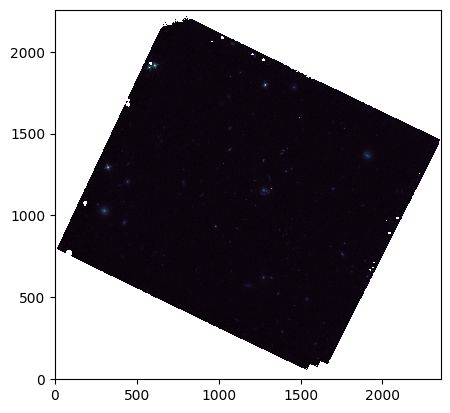

In [3]:
data, header = fits.getdata("/kaggle/input/fits-file/DESIJ09231829_F140W_drz_sci.fits", header=True)
plt.imshow(np.log10(data), origin="lower", cmap="cubehelix", interpolation="nearest")

## Background estimation

/tmp/ipykernel_33/3998831433.py:12: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background),


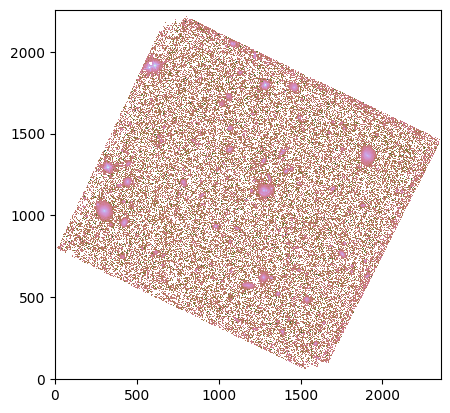

In [4]:
sigma_clip = SigmaClip(sigma=3.0)
bkg_estimator = MedianBackground()
bkg = Background2D(
    data,
    (50, 50),
    filter_size=(3, 3),
    sigma_clip=sigma_clip,
    bkg_estimator=bkg_estimator,
)

plt.imshow(
    np.log10(data - bkg.background),
    origin="lower",
    cmap="cubehelix",
    interpolation="nearest",
)

## Aperture Photometry and Plotting

/tmp/ipykernel_33/1402708730.py:25: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2


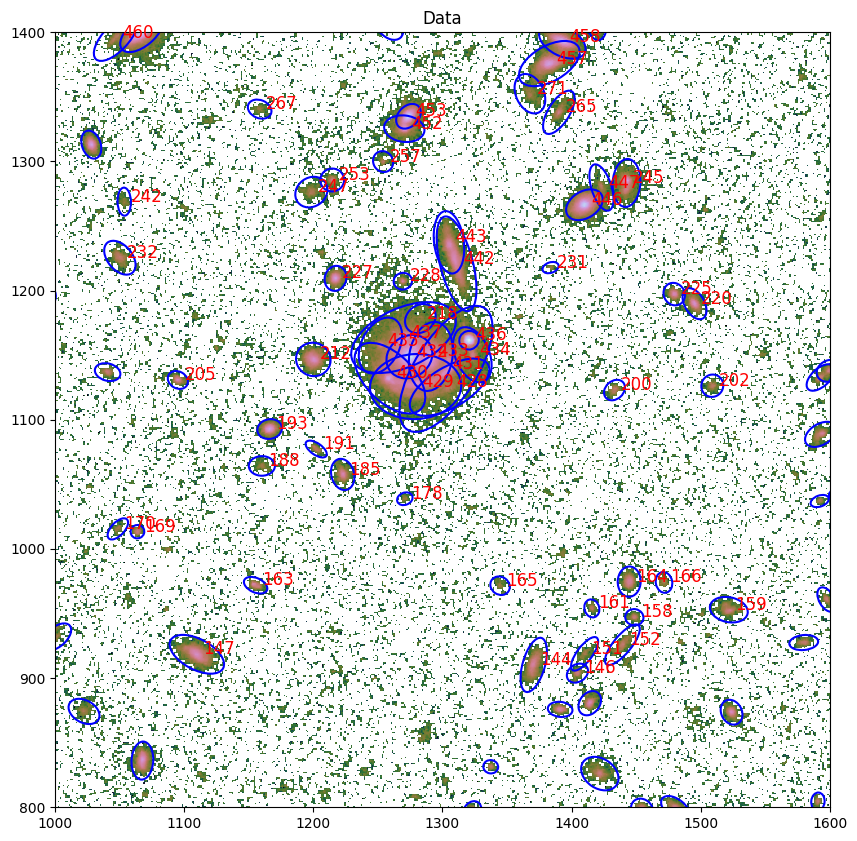

In [5]:
# Background subtraction
bkg_subtracted_data = data - bkg.background

# Source detection and segmentation
threshold = 4 * bkg.background_rms
segment_map = detect_sources(bkg_subtracted_data, threshold, npixels=10)
segm_deblend = deblend_sources(
    bkg_subtracted_data,
    segment_map,
    npixels=10,
    nlevels=32,
    contrast=0.001,
    progress_bar=False,
)

# Source catalog creation
finder = SourceFinder(npixels=10, progress_bar=False)
segment_map = finder(bkg_subtracted_data, threshold)
cat = SourceCatalog(bkg_subtracted_data, segm_deblend)

# Plotting
norm = simple_norm(data, "sqrt")
fig, ax1 = plt.subplots(1, 1, figsize=(10, 12.5))
ax1.imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
ax1.set_title("Data")

# Plot Kron apertures and label nearby sources
cat.plot_kron_apertures(ax=ax1, color="blue", lw=1.5)
for i in range(len(cat)):
    if (
        np.abs(cat.xcentroid[i] - cat.xcentroid[433]) < 250
        and np.abs(cat.ycentroid[i] - cat.ycentroid[433]) < 250
    ):
        ax1.text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

# Set axis limits
set_x_lim1, set_x_lim2 = 1000, 1600
set_y_lim1, set_y_lim2 = 800, 1400

ax1.set_xlim(set_x_lim1, set_x_lim2)
ax1.set_ylim(set_y_lim1, set_y_lim2)

# Hide text outside of the axes
ax1.set_clip_on(True)
ax1.set_clip_box(ax1.bbox)

# Show the plot
plt.show()

## Identify the central deflector's ID

/tmp/ipykernel_33/293312992.py:12: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background),


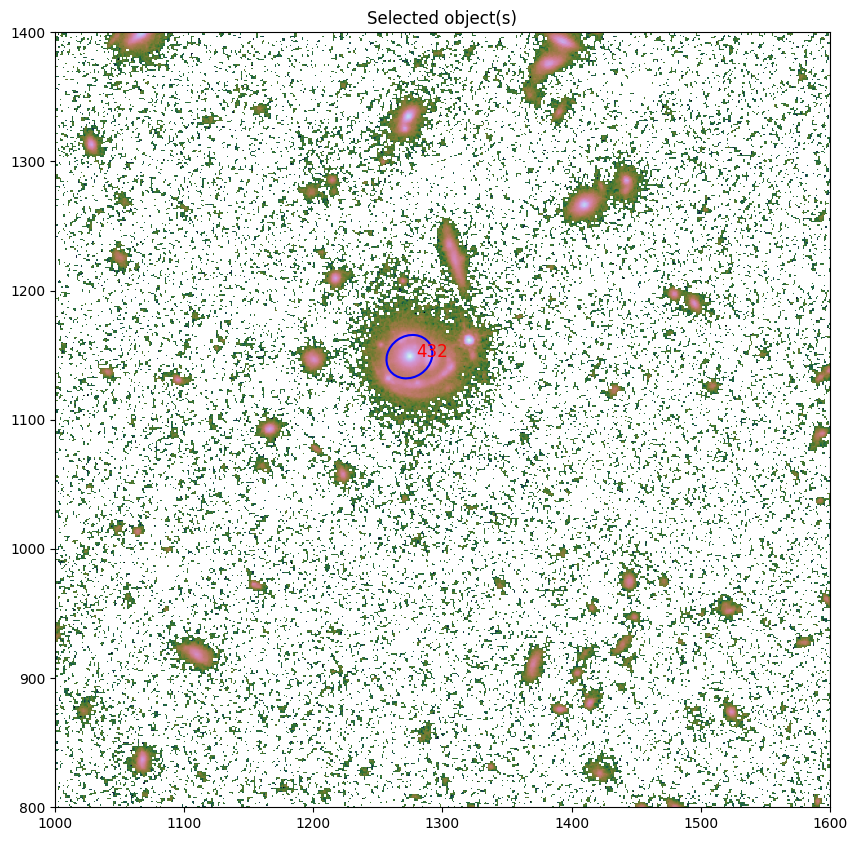

In [6]:
# Defining a function for labeling only selected objects


def label_selected_objects(selected_ids):
    # Background subtraction
    data - bkg.background

    # Plotting
    simple_norm(data, "sqrt")
    fig, ax1 = plt.subplots(1, 1, figsize=(10, 12.5))
    ax1.imshow(
        np.log10(data - bkg.background),
        origin="lower",
        cmap="cubehelix",
        vmin=-4,
        vmax=2,
    )
    ax1.set_title("Selected object(s)")

    # Plot Kron apertures and label selected objects
    for obj_id in selected_ids:
        labels = [obj_id + 1]
        cat_subset = cat.get_labels(labels)
        cat_subset.plot_kron_apertures(ax=ax1, color="blue", lw=1.5)

        ax1.text(
            cat.xcentroid[obj_id] + 5,
            cat.ycentroid[obj_id],
            f"{obj_id}",
            c="r",
            fontsize=12
            # transform=ax1.transAxes
        )

    # Set axis limits
    ax1.set_xlim(set_x_lim1, set_x_lim2)
    ax1.set_ylim(set_y_lim1, set_y_lim2)

    # Hide text outside of the axes
    ax1.set_clip_on(True)
    ax1.set_clip_box(ax1.bbox)

    # Show the plot
    plt.show()


# Guessing the lens galaxy
id_central = 432

# Calling the function label id_central
label_selected_objects([id_central])

In [7]:
# optional format
tbl = cat.to_table()
tbl["xcentroid"].info.format = ".2f"
tbl["ycentroid"].info.format = ".2f"
tbl["kron_flux"].info.format = ".2f"

## Creating A List of Neighboring Galaxies

In [8]:
# All close galaxies

x0 = tbl["xcentroid"].value[id_central]
y0 = tbl["ycentroid"].value[id_central]
f0 = tbl["kron_flux"].value[id_central]

close_galaxies_all = []
dist_galaxies_all = []
flux_galaxies_all = []
axis_ratios_all = []

for i in range(len(tbl)):
    if i == segment_map.nlabels:
        continue
    x = tbl["xcentroid"].value[i]
    y = tbl["ycentroid"].value[i]
    f = tbl["kron_flux"].value[i]
    if np.sqrt((x - x0) ** 2 + (y - y0) ** 2) < 25 / 0.08:
        close_galaxies_all.append(i)
        flux_galaxies_all.append(f)
        dist_galaxies_all.append(np.sqrt((x - x0) ** 2 + (y - y0) ** 2))
        axis_ratios_all.append(np.sqrt(1 - tbl[i]["eccentricity"].value ** 2))

print(
    "Number of all close galaxies within 25 arcsecond radius:", len(close_galaxies_all)
)

Number of all close galaxies within 25 arcsecond radius: 64


In [9]:
# Close galaxies excluding sources lower than 1% of the central deflector

x0 = tbl["xcentroid"].value[id_central]
y0 = tbl["ycentroid"].value[id_central]
f0 = tbl["kron_flux"].value[id_central]

close_galaxies_1 = []
dist_galaxies_1 = []
flux_galaxies_1 = []
axis_ratios_1 = []

for i in range(len(tbl)):
    if i == segment_map.nlabels:
        continue
    x = tbl["xcentroid"].value[i]
    y = tbl["ycentroid"].value[i]
    f = tbl["kron_flux"].value[i]
    if (np.sqrt((x - x0) ** 2 + (y - y0) ** 2) < 40 / 0.08) & (f > f0 * 0.01):
        close_galaxies_1.append(i)
        flux_galaxies_1.append(f)
        dist_galaxies_1.append(np.sqrt((x - x0) ** 2 + (y - y0) ** 2))
        axis_ratios_1.append(np.sqrt(1 - tbl[i]["eccentricity"].value ** 2))
print(
    "Number of close galaxies excluding dim sources within 40 arcsecond radius:",
    len(close_galaxies_1),
)

Number of close galaxies excluding dim sources within 40 arcsecond radius: 77


## Pixels to Megaparsec unit

In [10]:
def distance_parsec(pixel_distance):
    """Convert distance from unit of pixels into parsec unit.

    :param pixel_distance: distance in unit of pixels

    :return: distance in parsec unit

    """

    wcs = WCS(header)

    # Get the pixel scale in degrees per pixel
    pix_scale_deg = abs(wcs.wcs.cd[0, 0])

    # Convert the pixel scale from degrees to radians
    pix_scale_radian = pix_scale_deg * np.pi / 180
    
    # Angles in radians
    angles_radian = pixel_distance * pix_scale_radian
    
    # Define cosmological parameters
    H0 = 70   # Hubble constant in km/s/Mpc
    Om0 = 0.3 # Matter density parameter
    cosmo = FlatLambdaCDM(H0=H0, Om0=Om0)

    # Define the redshifts at which you want to compute the angular diameter distance
    z = 0.682
    
    # Compute the angular diameter distance
    angular_diameter_distance = cosmo.angular_diameter_distance(z)
    
    # Calculate the physical distance
    physical_distances_mpc = angular_diameter_distance * angles_radian 

    return physical_distances_mpc

## Identify the unwanted objects

/tmp/ipykernel_33/293312992.py:12: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background),


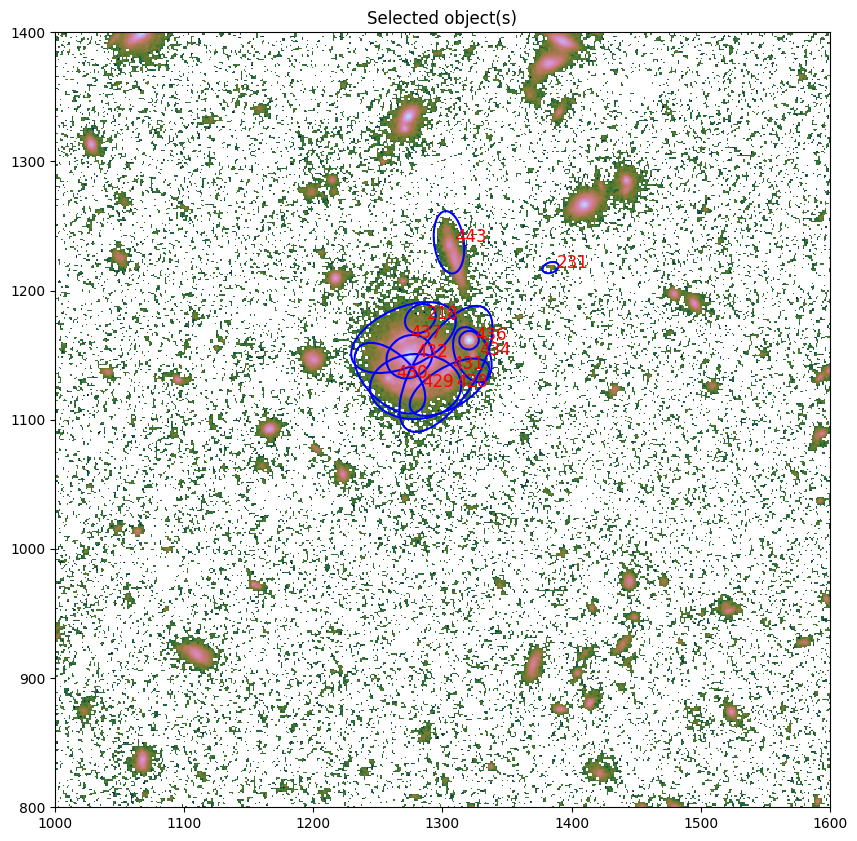

In [11]:
selected_object_ids = [218,231,428,429,430,431,432,434,436,437,443,]
label_selected_objects(selected_object_ids)

## Removing the unwanted objects from the neighboring galaxy list

In [12]:
# All close galaxies

# Lens galaxy: 432
# ARC objects: 218, 430, 429, 428, 431, 437
# Artifacts: 231, 443, 436, 434
# Probable Stars: 436
remove_list = [
    218,231,428,429,430,431,432,434,436,437,443,
]
df_all = pd.DataFrame({"Distance(pixels)": dist_galaxies_all})

df_all.set_index(pd.Index(close_galaxies_all), inplace=True)

df_all["Distance(megaparsec)"] = distance_parsec(df_all["Distance(pixels)"])
df_all["Flux"] = flux_galaxies_all
df_all["Axis Ratio"] = axis_ratios_all

# Sort the DataFrame based on 'Distance'
df_all_sorted = df_all.sort_values(by="Distance(pixels)")

# Exclude unwanted sources
df_all_sys_removed = df_all_sorted.drop(remove_list)

# first 20 galaxies
df_all_20 = df_all_sys_removed.iloc[:20]

print(df_all_20)

     Distance(pixels)  Distance(megaparsec)        Flux  Axis Ratio
433         16.614151              0.009398  256.523528    0.619029
435         24.028015              0.013592   46.283655    0.634613
228         58.647529              0.033175    6.981046    0.905456
212         74.423507              0.042099   59.071611    0.945524
442         80.635302              0.045613  105.512001    0.334771
227         83.346941              0.047147   39.212978    0.852448
191        101.582696              0.057462    5.137317    0.472075
185        104.812504              0.059289   21.678277    0.715104
178        110.064189              0.062260    1.789595    0.761156
193        121.864564              0.068935   48.483747    0.792121
188        142.136651              0.080402    4.938050    0.749636
247        148.306701              0.083892   10.368545    0.850826
253        149.256903              0.084430    8.785890    0.960463
257        152.389780              0.086202    4

In [13]:
# Excluding galaxies lower than 1% of the central deflector

# Lens galaxy: 432
# ARC objects: 218, 430, 429, 428, 431, 437
# Artifacts: 443, 436, 434
# Probable Stars: 436
remove_list_1 = [218,428,429,430,431,432,434,436,437,443,]

df_1 = pd.DataFrame({"Distance(pixels)": dist_galaxies_1})
df_1.set_index(pd.Index(close_galaxies_1), inplace=True)

df_1["Distance(megaparsec)"] = distance_parsec(df_1["Distance(pixels)"])
df_1["Flux"] = flux_galaxies_1
df_1["Axis Ratioe"] = axis_ratios_1

# Sort the DataFrame based on 'Distance'
df_1_sorted = df_1.sort_values(by="Distance(pixels)")

# Exclude the lensing system members
df_1_sys_removed = df_1_sorted.drop(remove_list_1)

# first 20 galaxies
df_1_20 = df_1_sys_removed.iloc[:20]

print(df_1_20)

     Distance(pixels)  Distance(megaparsec)        Flux  Axis Ratioe
433         16.614151              0.009398  256.523528     0.619029
435         24.028015              0.013592   46.283655     0.634613
212         74.423507              0.042099   59.071611     0.945524
442         80.635302              0.045613  105.512001     0.334771
227         83.346941              0.047147   39.212978     0.852448
185        104.812504              0.059289   21.678277     0.715104
193        121.864564              0.068935   48.483747     0.792121
247        148.306701              0.083892   10.368545     0.850826
253        149.256903              0.084430    8.785890     0.960463
452        176.538702              0.099862   51.197077     0.652576
446        179.421670              0.101493  213.164218     0.672642
205        180.171544              0.101917   12.999426     0.795674
453        186.107663              0.105275  196.458265     0.717085
447        198.137165             

## Calculating $\Sigma_{10}$, $\Sigma_{10, \rm flux\ selected}$, $\Sigma_{20}$, $\Sigma_{20, \rm flux\ selected}$ and the corresponding radii

## Method A

In [14]:
# For all sources
R_10_all = df_all_20.iloc[9, df_all_20.columns.get_loc("Distance(megaparsec)")] ## Change
R_20_all = df_all_20.iloc[19, df_all_20.columns.get_loc("Distance(megaparsec)")] ## Change
Sigma_10_allA = 10 / (np.pi * R_10_all**2)
Sigma_20_allA = 20 / (np.pi * R_20_all**2)

# Excluding dim sources
R_10_1 = df_1_20.iloc[9, df_1_20.columns.get_loc("Distance(megaparsec)")] ## Change
R_20_1 = df_1_20.iloc[19, df_1_20.columns.get_loc("Distance(megaparsec)")] ## Change
Sigma_10_1A = 10 / (np.pi * R_10_1**2)
Sigma_20_1A = 20 / (np.pi * R_20_1**2)


print("")
print("FOR All SOURCES")
print("R 10:", R_10_all)
print("R 20:", R_20_all)
print("Sigma 10:", Sigma_10_allA)
print("Sigma 20:", Sigma_20_allA)

print("")
print("EXCLUDING DIM SOURCES")
print("R 10:", R_10_1)
print("R 20:", R_20_1)
print("Sigma 10:", Sigma_10_1A)
print("Sigma 20:", Sigma_20_1A)


FOR All SOURCES
R 10: 0.06893480083243826
R 20: 0.10788679229752454
Sigma 10: 669.8430828721096
Sigma 20: 546.9448802010445

EXCLUDING DIM SOURCES
R 10: 0.09986217371839297
R 20: 0.12699546820103097
Sigma 10: 319.1891328757084
Sigma 20: 394.7332186666142


## Method B

In [15]:
weighted_flux_10_all = np.sum(df_all_20["Flux"][0:10] / np.max(df_all_20["Flux"][0:10]))
weighted_flux_20_all = np.sum(df_all_20["Flux"][0:20] / np.max(df_all_20["Flux"][0:20]))
Sigma_10_allB = weighted_flux_10_all / (np.pi * R_10_all**2)
Sigma_20_allB = weighted_flux_20_all / (np.pi * R_20_all**2)


weighted_flux_10_1 = np.sum(df_1_20["Flux"][0:10] / np.max(df_1_20["Flux"][0:10]))
weighted_flux_20_1 = np.sum(df_1_20["Flux"][0:20] / np.max(df_1_20["Flux"][0:20]))
Sigma_10_1B = weighted_flux_10_1 / (np.pi * R_10_1**2)
Sigma_20_1B = weighted_flux_20_1 / (np.pi * R_20_1**2)


print("")
print("Considering Light Flux")
print("FOR All SOURCES")
print("R 10:", R_10_all)
print("R 20:", R_20_all)
print("Sigma 10_updated:", Sigma_10_allB)
print("Sigma 20_updated:", Sigma_20_allB)

print("")
print("EXCLUDING DIM SOURCES")
print("R 10:", R_10_1)
print("R 20:", R_20_1)
print("Sigma 10_updated:", Sigma_10_1B)
print("Sigma 20_updated:", Sigma_20_1B)


Considering Light Flux
FOR All SOURCES
R 10: 0.06893480083243826
R 20: 0.10788679229752454
Sigma 10_updated: 154.23876761202953
Sigma 20_updated: 117.63675929828374

EXCLUDING DIM SOURCES
R 10: 0.09986217371839297
R 20: 0.12699546820103097
Sigma 10_updated: 80.52002631349482
Sigma 20_updated: 94.2324043191927


## Method C

In [16]:
flux_10_all = []
flux_20_all = []
flux_10_1 = []
flux_20_1 = []

# for all sources
for i in range(20):
    flux_all = df_all_20["Flux"][i:i+1] / df_all_20["Distance(megaparsec)"][i:i+1]
    
    if i < 10:
        flux_10_all.append(flux_all)
        flux_20_all.append(flux_all)
        
    elif 9 < i < 20:
        flux_20_all.append(flux_all)
        
weighted_flux_10_all = np.sum(flux_10_all / np.max(flux_10_all))
weighted_flux_20_all = np.sum(flux_20_all / np.max(flux_20_all))
Sigma_10_allC = weighted_flux_10_all  / (np.pi * R_10_all**2)
Sigma_20_allC = weighted_flux_20_all / (np.pi * R_20_all**2)

# excluding dim sources
for i in range(20):
    flux_1 = df_1_20["Flux"][i:i+1] / df_1_20["Distance(megaparsec)"][i:i+1]
    
    if i < 10:
        flux_10_1.append(flux_1)
        flux_20_1.append(flux_1)
        
    elif 9 < i < 20:
        flux_20_1.append(flux_1)
        
weighted_flux_10_1 = np.sum(flux_10_1 / np.max(flux_10_1))
weighted_flux_20_1 = np.sum(flux_20_1 / np.max(flux_20_1))
Sigma_10_1C = weighted_flux_10_1 / (np.pi * R_10_1**2)
Sigma_20_1C = weighted_flux_20_1 / (np.pi * R_20_1**2)


print("")
print("Considering Light Flux And Distance")
print("FOR All SOURCES")
print("R 10:", R_10_all)
print("R 20:", R_20_all)
print("Sigma 10_updated:", Sigma_10_allC)
print("Sigma 20_updated:", Sigma_20_allC)

print("")
print("EXCLUDING DIM SOURCES")
print("R 10:", R_10_1)
print("R 20:", R_20_1)
print("Sigma 10_updated:", Sigma_10_1C)
print("Sigma 20_updated:", Sigma_20_1C)


Considering Light Flux And Distance
FOR All SOURCES
R 10: 0.06893480083243826
R 20: 0.10788679229752454
Sigma 10_updated: 89.93194645324239
Sigma 20_updated: 41.782312418016794

EXCLUDING DIM SOURCES
R 10: 0.09986217371839297
R 20: 0.12699546820103097
Sigma 10_updated: 43.33526948865035
Sigma 20_updated: 30.673132237688893


## Method D

In [17]:
# Initialize flux variables
flux_10_all = []
flux_20_all = []
flux_10_1 = []
flux_20_1 = []

# Define a short radius
pixel_distance = 125 # for 10 arcseconds
s = distance_parsec(pixel_distance).value

# Process both dataframes
for i in range(20):
    distance_all = df_all_20["Distance(megaparsec)"].iloc[i]
    flux_all = df_all_20["Flux"].iloc[i]
    distance_1 = df_1_20["Distance(megaparsec)"].iloc[i]
    flux_1 = df_1_20["Flux"].iloc[i]
    
    # Processing for df_all_20
    if i < 10:
        if distance_all <= s:
            flux_contrib_all = flux_all / s
        else:
            flux_contrib_all = flux_all / distance_all
        
        flux_10_all.append(flux_contrib_all)
        flux_20_all.append(flux_contrib_all)
        
    elif 9 < i < 20:
        if distance_all <= s:
            flux_contrib_all = flux_all / s
        else:
            flux_contrib_all = flux_all / distance_all
        
        flux_20_all.append(flux_contrib_all)
    
    # Processing for df_1_20
    if i < 10:
        
        if distance_1 <= s:
            flux_contrib_1 = flux_1 / s
        else:
            flux_contrib_1 = flux_1 / distance_1
        
        flux_10_1.append(flux_contrib_1)
        flux_20_1.append(flux_contrib_1)
        
    elif 9 < i < 20:
        if distance_1 <= s:
            flux_contrib_1 = flux_1 / s
        else:
            flux_contrib_1 = flux_1 / distance_1
        
        flux_20_1.append(flux_contrib_1)

weighted_flux_10_all = np.sum(flux_10_all / np.max(flux_10_all))
weighted_flux_20_all = np.sum(flux_20_all / np.max(flux_20_all))
Sigma_10_allD = weighted_flux_10_all / (np.pi * R_10_all**2)
Sigma_20_allD = weighted_flux_20_all / (np.pi * R_20_all**2)

weighted_flux_10_1 = np.sum(flux_10_1 / np.max(flux_10_1))
weighted_flux_20_1 = np.sum(flux_20_1 / np.max(flux_20_1))
Sigma_10_1D = weighted_flux_10_1 / (np.pi * R_10_1**2)
Sigma_20_1D = weighted_flux_20_1 / (np.pi * R_20_1**2)


# Print results
print("")
print("Considering Light Flux And Distance")
print("FOR All SOURCES")
print("R 10:", R_10_all)
print("R 20:", R_20_all)
print("Sigma 10_updated:", Sigma_10_allD)
print("Sigma 20_updated:", Sigma_20_allD)

print("")
print("EXCLUDING DIM SOURCES")
print("R 10:", R_10_1)
print("R 20:", R_20_1)
print("Sigma 10_updated:", Sigma_10_1D)
print("Sigma 20_updated:", Sigma_20_1D)



Considering Light Flux And Distance
FOR All SOURCES
R 10: 0.06893480083243826
R 20: 0.10788679229752454
Sigma 10_updated: 154.23876761202953
Sigma 20_updated: 101.08805844084804

EXCLUDING DIM SOURCES
R 10: 0.09986217371839297
R 20: 0.12699546820103097
Sigma 10_updated: 78.27983842804333
Sigma 20_updated: 77.57510469534192


## Visualization

/tmp/ipykernel_33/4146286428.py:17: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
/tmp/ipykernel_33/4146286428.py:20: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
/tmp/ipykernel_33/4146286428.py:23: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
/tmp/ipykernel_33/4146286428.py:26: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2


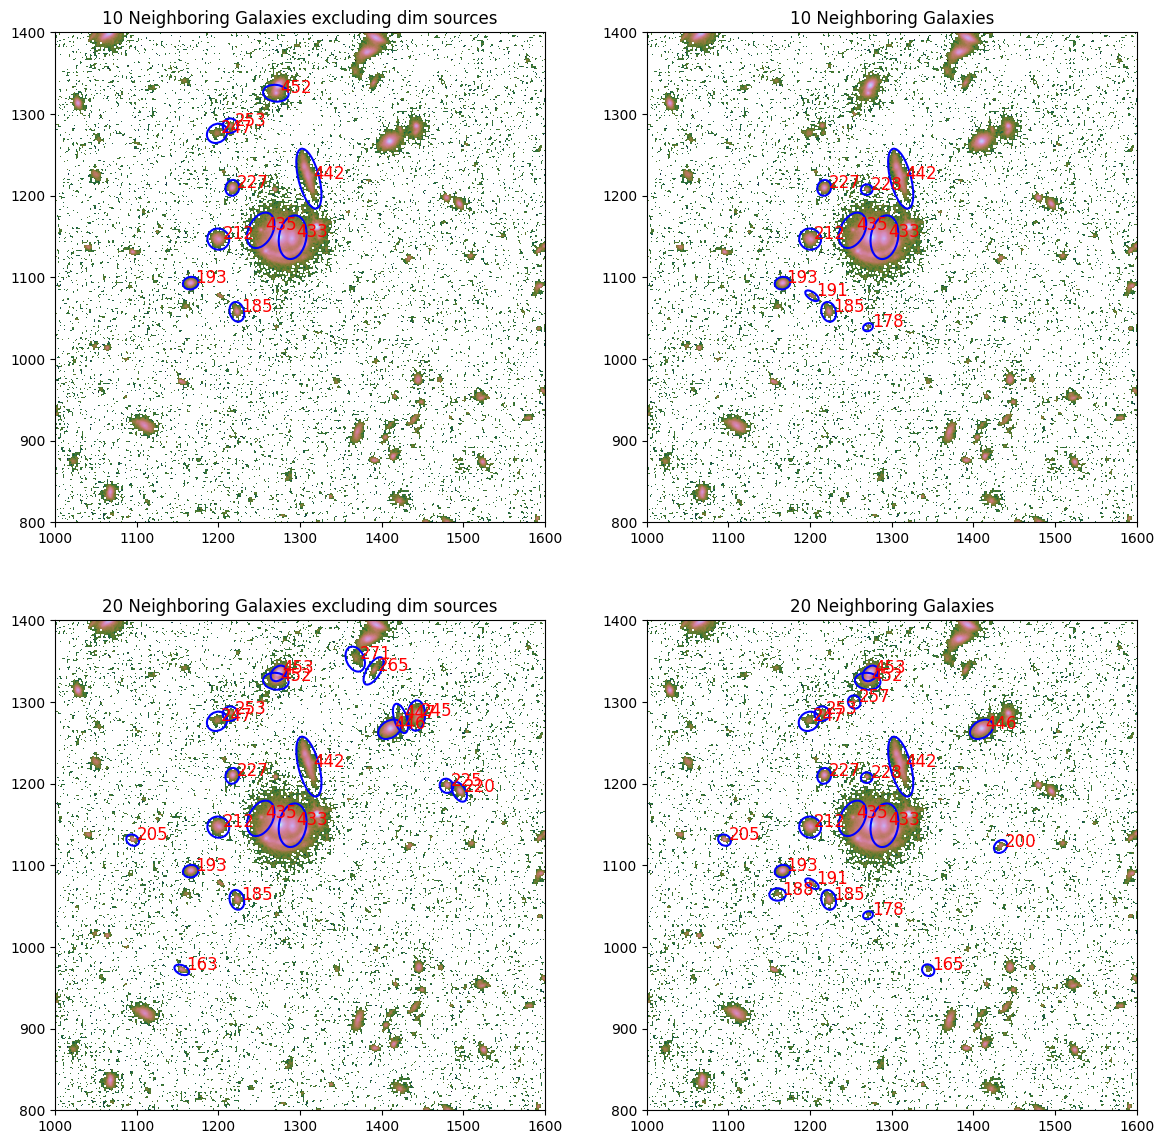

In [18]:
close_ids_all = list(df_all_20.index.values)
close_ids_all_10 = close_ids_all[:10]

updated_close_ids_all = [s + 1 for s in close_ids_all]
updated_close_ids_all_10 = updated_close_ids_all[:10]

close_ids_1 = list(df_1_20.index.values)
close_ids_1_10 = close_ids_1[:10]

updated_close_ids_1 = [s + 1 for s in close_ids_1]
updated_close_ids_1_10 = updated_close_ids_1[:10]

norm = simple_norm(data, "sqrt")
fig, axs = plt.subplots(2, 2, figsize=(14, 14))

axs[0, 0].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
axs[0, 1].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
axs[1, 0].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
axs[1, 1].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)

cat_subset_1_10 = cat.get_labels(updated_close_ids_1_10)
cat_subset_1_10.plot_kron_apertures(ax=axs[0, 0], color="blue", lw=1.5)

cat_subset_all_10 = cat.get_labels(updated_close_ids_all_10)
cat_subset_all_10.plot_kron_apertures(ax=axs[0, 1], color="blue", lw=1.5)

cat_subset_all = cat.get_labels(updated_close_ids_1)
cat_subset_all.plot_kron_apertures(ax=axs[1, 0], color="blue", lw=1.5)

cat_subset_1 = cat.get_labels(updated_close_ids_all)
cat_subset_1.plot_kron_apertures(ax=axs[1, 1], color="blue", lw=1.5)

axs[0, 0].set_title("10 Neighboring Galaxies excluding dim sources")
axs[0, 1].set_title("10 Neighboring Galaxies")
axs[1, 0].set_title("20 Neighboring Galaxies excluding dim sources")
axs[1, 1].set_title("20 Neighboring Galaxies")

for i in close_ids_1_10:
    axs[0, 0].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

for i in close_ids_all_10:
    axs[0, 1].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

for i in close_ids_1:
    axs[1, 0].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

for i in close_ids_all:
    axs[1, 1].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

axs[0, 0].set_xlim(set_x_lim1, set_x_lim2)
axs[0, 0].set_ylim(set_y_lim1, set_y_lim2)

axs[0, 1].set_xlim(set_x_lim1, set_x_lim2)
axs[0, 1].set_ylim(set_y_lim1, set_y_lim2)

axs[1, 0].set_xlim(set_x_lim1, set_x_lim2)
axs[1, 0].set_ylim(set_y_lim1, set_y_lim2)

axs[1, 1].set_xlim(set_x_lim1, set_x_lim2)
axs[1, 1].set_ylim(set_y_lim1, set_y_lim2)

# hide all text outside of the axes
axs[0, 0].set_clip_on(True)
axs[0, 0].set_clip_box(axs[0, 0].bbox)

axs[0, 1].set_clip_on(True)
axs[0, 1].set_clip_box(axs[0, 0].bbox)

axs[1, 0].set_clip_on(True)
axs[1, 0].set_clip_box(axs[0, 0].bbox)

axs[1, 1].set_clip_on(True)
axs[1, 1].set_clip_box(axs[0, 0].bbox)

## Store the results to the YAML file

In [19]:
# Existing YAML file with other parameters
existing_yaml_file = "DESIJ0923+1829_point_estimates.yml"

# Variables to include in the YAML file
environment_variables = {
    "Sigma_10a_flux_selected": Sigma_10_1A,
    "Sigma_20a_flux_selected": Sigma_20_1A,
    "Sigma_10a": Sigma_10_allA,
    "Sigma_20a": Sigma_20_allA,
    
    "Sigma_10b_flux_selected": Sigma_10_1B,
    "Sigma_20b_flux_selected": Sigma_20_1B,
    "Sigma_10b": Sigma_10_allB,
    "Sigma_20b": Sigma_20_allB,
    
    "Sigma_10c_flux_selected": Sigma_10_1C,
    "Sigma_20c_flux_selected": Sigma_20_1C,
    "Sigma_10c": Sigma_10_allC,
    "Sigma_20c": Sigma_20_allC,
    
    "Sigma_10d_flux_selected": Sigma_10_1D,
    "Sigma_20d_flux_selected": Sigma_20_1D,
    "Sigma_10d": Sigma_10_allD,
    "Sigma_20d": Sigma_20_allD
}

# make all the numpy variales to float
environment_variables = {
    key: [float(item) for item in value] if isinstance(value, list) else float(value)
    for key, value in environment_variables.items()
}

# Load existing YAML content if the file exists
existing_content = {}
try:
    with open(existing_yaml_file, "r") as file:
        existing_content = yaml.safe_load(file)
except FileNotFoundError:
    pass

# Update the existing content with new variables
existing_content.update(environment_variables)

# Write the updated content back to the YAML file
with open(existing_yaml_file, "w") as file:
    yaml.dump(existing_content, file, default_flow_style=False)

In [20]:
with open(existing_yaml_file, "r") as file:
    try:
        yaml_read = yaml.safe_load(file)
        print("YAML Data:")
        print("Number of params:", len(list(yaml_read.keys())))
        print(yaml_read)
    except yaml.YAMLError as e:
        print(f"Error reading YAML file: {e}")

YAML Data:
Number of params: 16
{'Sigma_10a': 669.8430828721096, 'Sigma_10a_flux_selected': 319.1891328757084, 'Sigma_10b': 154.23876761202953, 'Sigma_10b_flux_selected': 80.52002631349482, 'Sigma_10c': 89.93194645324239, 'Sigma_10c_flux_selected': 43.33526948865035, 'Sigma_10d': 154.23876761202953, 'Sigma_10d_flux_selected': 78.27983842804333, 'Sigma_20a': 546.9448802010445, 'Sigma_20a_flux_selected': 394.7332186666142, 'Sigma_20b': 117.63675929828374, 'Sigma_20b_flux_selected': 94.2324043191927, 'Sigma_20c': 41.782312418016794, 'Sigma_20c_flux_selected': 30.673132237688893, 'Sigma_20d': 101.08805844084804, 'Sigma_20d_flux_selected': 77.57510469534192}
